In [27]:
# Install required packages
!pip3 install gymnasium[classic_control] optuna

# Imports
import math
import random
from collections import namedtuple, deque
from itertools import count

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [28]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [39]:
class NoisyLinear(nn.Linear):
    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        self.sigma_weight = nn.Parameter(torch.full((out_features, in_features), sigma_init))
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = nn.Parameter(torch.full((out_features,), sigma_init))
            self.register_buffer("epsilon_bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        if self.bias is not None:
            self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self.sigma_bias * self.epsilon_bias.data
        return F.linear(input, self.weight + self.sigma_weight * self.epsilon_weight.data, bias)


In [40]:
class DuelingDQN(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_size, noisy=False, sigma_init=0.017):
        super(DuelingDQN, self).__init__()
        Linear = NoisyLinear if noisy else nn.Linear

        self.base = nn.Sequential(
            Linear(n_observations, hidden_size),
            nn.ReLU(),
            Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        self.adv_layer = nn.Sequential(
            Linear(hidden_size, hidden_size),
            nn.ReLU(),
            Linear(hidden_size, n_actions),
        )

        self.val_layer = nn.Sequential(
            Linear(hidden_size, hidden_size),
            nn.ReLU(),
            Linear(hidden_size, 1),
        )

    def forward(self, x):
        x = self.base(x)
        advantage = self.adv_layer(x)
        value = self.val_layer(x)
        return value + advantage - advantage.mean(dim=1, keepdim=True)


In [41]:
class DuelingDQNAgent:
    def __init__(self, env, trial, noisy=False):
        self.env = env
        self.device = device

        # Hyperparameters from Optuna
        self.batch_size = trial.suggest_int("batch_size", 32, 256)
        self.gamma = trial.suggest_float("gamma", 0.9, 0.99)
        self.lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        self.hidden_size = trial.suggest_int("hidden_size", 64, 512)
        self.memory_size = trial.suggest_int("memory_size", 5000, 20000)
        self.eps_start = trial.suggest_float("eps_start", 0.8, 1.0)
        self.eps_end = trial.suggest_float("eps_end", 0.01, 0.1)
        self.eps_decay = trial.suggest_int("eps_decay", 500, 2000)

        # Initialize networks
        n_actions = env.action_space.n
        n_observations = len(env.observation_space.low)

        self.policy_net = DuelingDQN(n_observations, n_actions, self.hidden_size, noisy).to(self.device)
        self.target_net = DuelingDQN(n_observations, n_actions, self.hidden_size, noisy).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(self.memory_size)

        self.steps_done = 0

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1.0 * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()


In [42]:
def objective(trial):
    env = gym.make("CartPole-v1")
    noisy = trial.suggest_categorical("noisy_layers", [True, False])
    agent = DuelingDQNAgent(env, trial, noisy)

    n_episodes = 100
    episode_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
        episode_reward = 0

        for t in range(500):
            action = agent.select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=agent.device)
            episode_reward += reward

            done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
            agent.memory.push(state, action, next_state, reward)
            state = next_state

            agent.optimize_model()

            if done:
                break

        episode_rewards.append(episode_reward.item())

    return np.mean(episode_rewards[-10:])


In [37]:
import matplotlib.pyplot as plt
from IPython import display

# Store episode durations for plotting
episode_durations = []

def plot_durations(show_result=False):
    """
    Plot the durations of each episode along with a moving average.
    If `show_result` is True, the plot will display 'Result' in the title.
    """
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    # Compute and plot moving average (window size = 100)
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # Pause to update the plot
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


In [43]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-01-27 23:07:50,676] A new study created in memory with name: no-name-30ba1ff0-dce9-45ef-a31b-574e0ea1a522
[I 2025-01-27 23:07:53,385] Trial 0 finished with value: 10.8 and parameters: {'noisy_layers': True, 'batch_size': 88, 'gamma': 0.9703670177653123, 'lr': 0.00015889139972552176, 'hidden_size': 237, 'memory_size': 14737, 'eps_start': 0.8380837759709722, 'eps_end': 0.08819650359729166, 'eps_decay': 541}. Best is trial 0 with value: 10.8.
[I 2025-01-27 23:07:57,867] Trial 1 finished with value: 19.4 and parameters: {'noisy_layers': True, 'batch_size': 182, 'gamma': 0.9688479282245426, 'lr': 1.1345015559739135e-05, 'hidden_size': 255, 'memory_size': 16960, 'eps_start': 0.8466510952950257, 'eps_end': 0.060504914585289025, 'eps_decay': 1899}. Best is trial 1 with value: 19.4.
[I 2025-01-27 23:07:59,847] Trial 2 finished with value: 12.8 and parameters: {'noisy_layers': False, 'batch_size': 190, 'gamma': 0.9531138989473753, 'lr': 6.975876787679742e-05, 'hidden_size': 332, 'memory_

Best trial:
  Value:  44.0
  Params: 
    noisy_layers: False
    batch_size: 128
    gamma: 0.9548189334740008
    lr: 0.0005894191791766714
    hidden_size: 65
    memory_size: 8793
    eps_start: 0.9162211117794632
    eps_end: 0.04575045450668665
    eps_decay: 1682


In [48]:
# Let's add the plots back

In [44]:
import matplotlib.pyplot as plt
from IPython import display

# Store episode durations for plotting
episode_durations = []

def plot_durations(show_result=False):
    """
    Plot the durations of each episode along with a moving average.
    If `show_result` is True, the plot will display 'Result' in the title.
    """
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    # Compute and plot moving average (window size = 100)
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # Pause to update the plot
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


In [45]:
def objective(trial):
    env = gym.make("CartPole-v1")
    noisy = trial.suggest_categorical("noisy_layers", [True, False])
    agent = DuelingDQNAgent(env, trial, noisy)

    n_episodes = 100
    global episode_durations  # To track durations across episodes
    episode_durations = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
        episode_reward = 0

        for t in range(500):
            action = agent.select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=agent.device)
            episode_reward += reward

            done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)
            agent.memory.push(state, action, next_state, reward)
            state = next_state

            agent.optimize_model()

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break

    plot_durations(show_result=True)
    return np.mean(episode_durations[-10:])


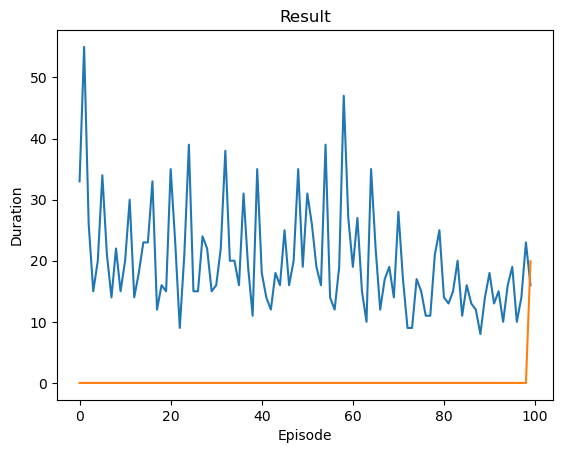

<Figure size 640x480 with 0 Axes>

[I 2025-01-27 23:20:03,568] Trial 49 finished with value: 15.4 and parameters: {'noisy_layers': True, 'batch_size': 150, 'gamma': 0.9593597299546295, 'lr': 3.584455027324644e-05, 'hidden_size': 312, 'memory_size': 15039, 'eps_start': 0.9934088895803803, 'eps_end': 0.01437546594831872, 'eps_decay': 1298}. Best is trial 47 with value: 65.0.


Best trial:
  Value:  65.0
  Params: 
    noisy_layers: False
    batch_size: 149
    gamma: 0.96118298038666
    lr: 7.510378414408895e-05
    hidden_size: 434
    memory_size: 9576
    eps_start: 0.9908142294636945
    eps_end: 0.010358860195884913
    eps_decay: 1554


In [47]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Optimization complete.


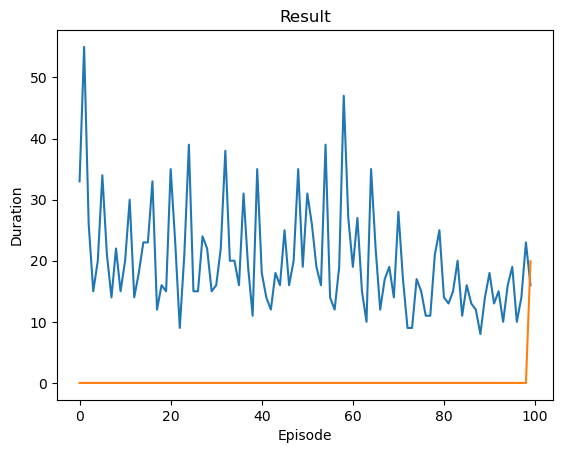

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [49]:
# After the Optuna study is complete, display the final plot
print("Optimization complete.")
plot_durations(show_result=True)
plt.ioff()  # Disable interactive mode
plt.show()  # Display the final result


In [50]:
# the results look terrible... 